<a href="https://colab.research.google.com/github/SefaWork/PillBlisterCounter/blob/main/Pill_Blister_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pill Blister Detector

by Mehmet Sefa Toksoy and Elif Ceyda Civelek

Github page: https://github.com/SefaWork/PillBlisterCounter

## Introduction

This is an algorithm designed to detect circular blisters in an image by using image processing / computer vision methods. It is based on this article: https://www.mdpi.com/1424-8220/22/8/2958

## Teamwork

Mehmet Sefa Toksoy: Creating google colab, github pages. Libraries, image uploading, image detection and a little bit on image acquisition and image preprocessing.

Elif Ceyda Civelek: Majority of image acquisition and image preprocessing. Majority of presentation preparation.

## Instructions

1.   Run the Libraries code block.
2.   Run the Uploading Files code block and upload an image. (Test images are provided in the github page!)
3.   Run the Image Detection Algorithm code block and observe. It can help to zoom out your page to see the generated images a little better.

## Libraries

These are the libraries that the code needs to function. Run this code block first.

In [ ]:
#importing needed libraries (Run this code first.)
from google.colab.patches import cv2_imshow # for image display
from google.colab import files # for file uploading

import cv2 # for image processing
import numpy as np # for image processing matrix math

libraries_loaded = True

print("✅ You are good to go! You may now upload an image file.")



✅ You are good to go! You may now upload an image file.


## Uploading Files

This code block allows you to upload an image file. You must run this first if you wish to run the image detection algorithm. Will throw an error if you didn't run the libraries code block.

Saving brave_7uHQMin9Sn.png to brave_7uHQMin9Sn (2).png


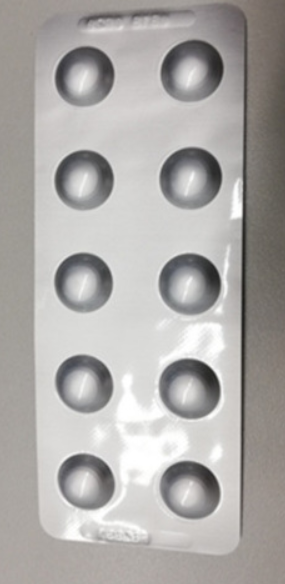

> Type in the expected number of blisters (or type 0): 
10


✅ You are good to go! You can run the next code block now.


In [ ]:
# Throw an exception if libraries are not loaded yet.
if not ('libraries_loaded' in globals()):
  raise Exception("❌ Libraries must be loaded first. Run the first code block in this notebook.")

# Create image uploading GUI and wait for upload. Only take the first image.
uploaded = list(files.upload().keys())[0]

# Throw an exception if no files were uploaded.
if not uploaded:
  raise Exception("❌ You did not upload a file.")

cv2_imshow(cv2.imread(uploaded))
total_expected_blister_count = 0;

print("> Type in the expected number of blisters (or type 0): ")
user_input = int(input())

if(user_input < 0):
  raise Exception("❌ Expected number of blisters cannot be negative.")

total_expected_blister_count = user_input

print("\n\n✅ You are good to go! You can run the next code block now.")

## Image Detection Algorithm

This code will take the file you uploaded and process it to find any pills. This only works for pill blisters that are small, gray (non-transparent) and in a dark environment. The methods below were developed with the guidance of this article: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9028233/

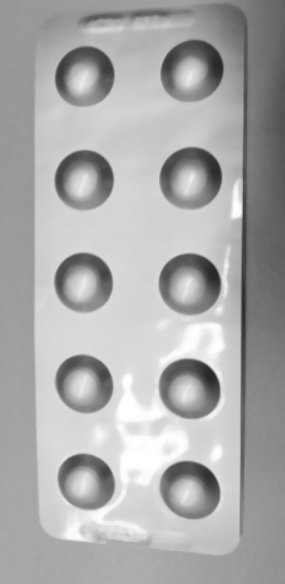

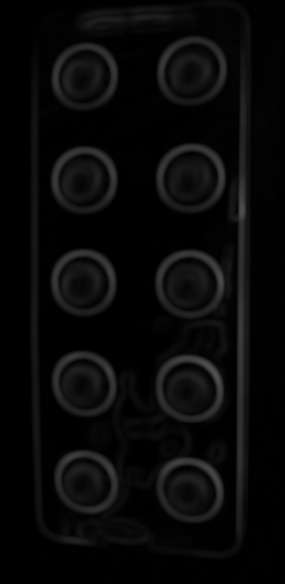

<ipython-input-23-6fd5e97ada7f>:28: RuntimeWarning: invalid value encountered in cast
  binarized = cv2.threshold(std_filtered.astype(np.uint8), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]


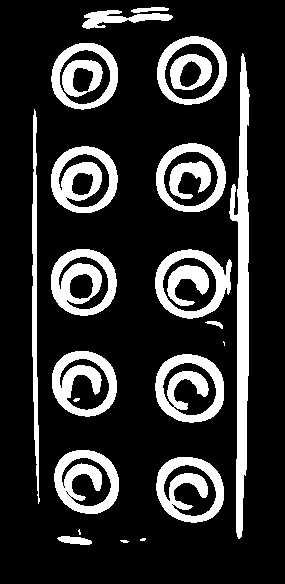

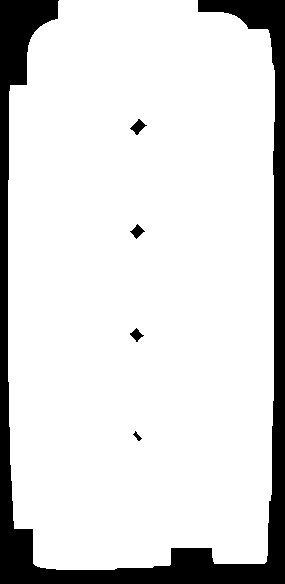

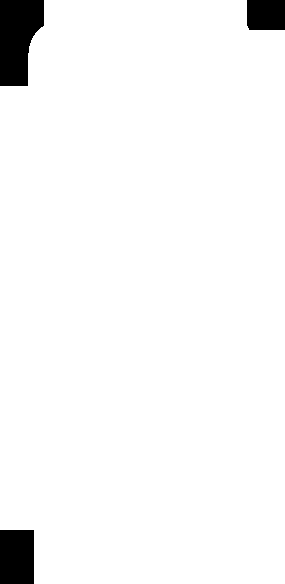

New resolution is: 488 width / 1000 height


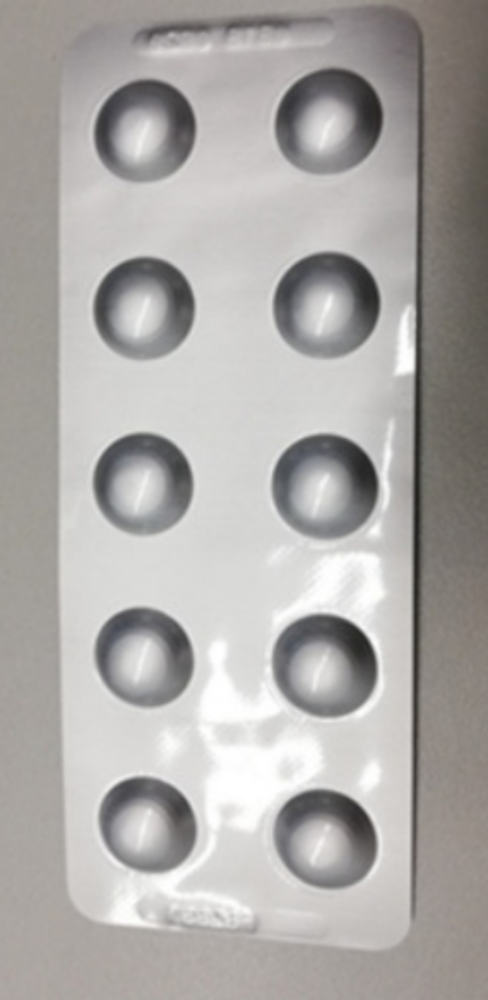

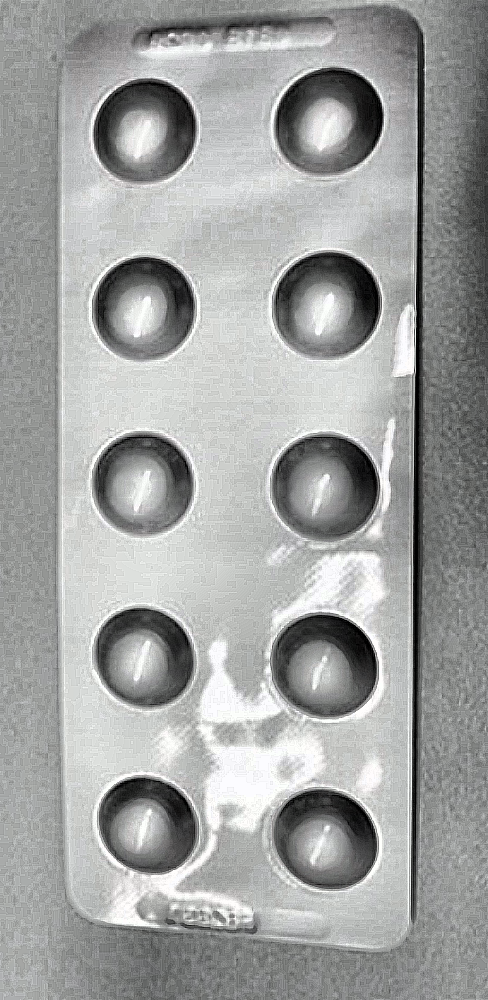

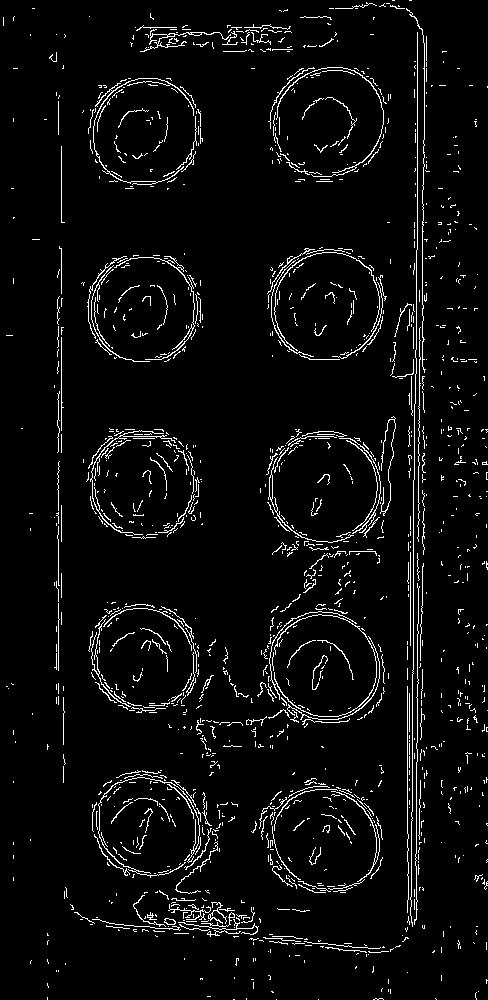

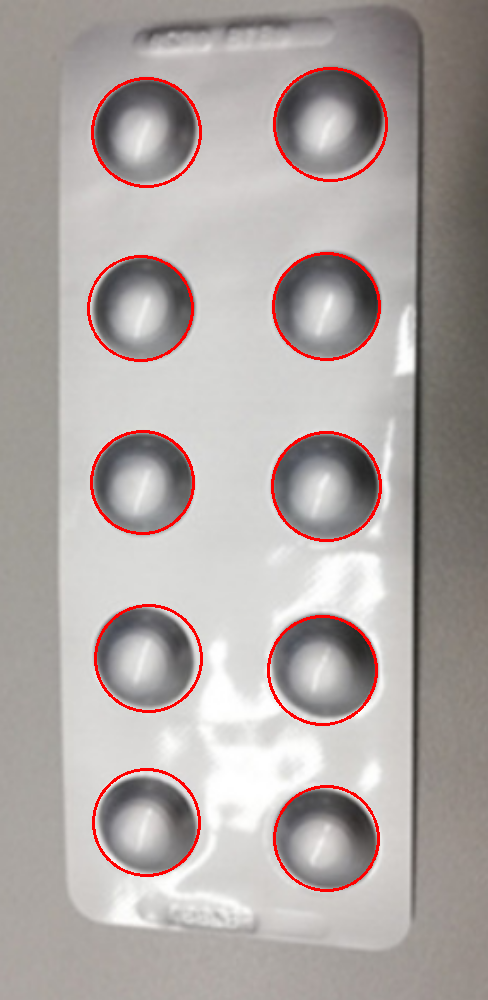



✅ Successfully detected 10 blisters as the user specified.


In [ ]:
if not ('uploaded' in globals()) or uploaded is None:
  raise Exception("❌ Please upload an image first using the previous code block.")

# Load the image.
img = cv2.imread(uploaded).astype(np.float32)

### STAGE 1, IMAGE ACQUISITION ###
# Convert to grayscale.
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Apply 5x5 median filter.
blurred = cv2.medianBlur(gray, 5)
cv2_imshow(blurred)

# Apply 9x9 STD (Standart Deviation Filter)
blurred2 = blurred**2
ones = np.ones(blurred.shape)
kernel = np.ones((9,9))

s = cv2.filter2D(blurred, cv2.CV_32F, kernel)
s2 = cv2.filter2D(blurred2, cv2.CV_32F, kernel)
ns = cv2.filter2D(ones, cv2.CV_32F, kernel)

std_filtered = cv2.sqrt((s2 - s**2 / ns) / ns)
cv2_imshow(std_filtered)

# Binarization (Thresholding)
binarized = cv2.threshold(std_filtered.astype(np.uint8), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
cv2_imshow(binarized)

# Dilation 50x50
dilated = cv2.dilate(binarized, np.ones((50,50), np.uint8))
cv2_imshow(dilated)

# Closing Operation
closed = cv2.morphologyEx(dilated, cv2.MORPH_CLOSE, np.ones((50,50), np.uint8))
cv2_imshow(closed)

# Get image contours as bounding boxes and select the largest one as our object. (Image segmentation)
contours, _ = cv2.findContours(closed, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

largest_contour_area = 0
largest_contour = None

for contour in contours:
  # Get bounding box.
  x, y, w, h = cv2.boundingRect(contour)

  # Get bounding box area.
  contour_bounding_area = w * h

  if largest_contour_area < contour_bounding_area:
    largest_contour_area = contour_bounding_area
    largest_contour = contour

if largest_contour is None:
  raise Exception("No contours found.")

# Get bounding box, scale the image to be (x:1000) dimensions (aspect ratio is maintained!) AND rotate to be vertically aligned.
x, y, w, h = cv2.boundingRect(largest_contour)
crop_img = img[y:y+h, x:x+w]

aspect_ratio = w / h

if w > h:
  w = 1000
  h = int(w / aspect_ratio)
  crop_img = cv2.rotate(cv2.resize(crop_img, (w, h)), cv2.ROTATE_90_CLOCKWISE) # Rotate by 90 degrees.
else:
  h = 1000
  w = int(h * aspect_ratio)
  crop_img = cv2.resize(crop_img, (w, h))

print("New resolution is: {w} width / {h} height".format(w=crop_img.shape[1], h=crop_img.shape[0]))

cv2_imshow(crop_img)

### STEP 2, IMAGE PREPROCESSING ###
# Convert from RGB color space to HSV color space.
hsv = cv2.cvtColor(crop_img, cv2.COLOR_BGR2HSV).astype(np.uint8)

# Create CLAHE filter and apply it to H, S and V channels.
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
hsv[:,:,0] = clahe.apply(hsv[:,:,0])
hsv[:,:,1] = clahe.apply(hsv[:,:,1])
hsv[:,:,2] = clahe.apply(hsv[:,:,2])

# Sharpen V channel.
sharp_kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
hsv[:,:,2] = cv2.filter2D(hsv[:,:,2], -1, sharp_kernel)

rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
cv2_imshow(rgb)

### STEP 3, BLISTER DETECTION ###
# Canny edge detection on the value channel.
canny = cv2.Canny(hsv[:,:,2], 145, 200)
cv2_imshow(canny)

# Circle detection using Hough transforms
circles = cv2.HoughCircles(canny, cv2.HOUGH_GRADIENT, 1, canny.shape[0] / 8, param1=100, param2=30, minRadius=30, maxRadius=100)

if circles is None:
  raise Exception("❌ No blisters were found in the image.")

circles = np.uint16(np.around(circles))

# Count the circles, highlight them and report.
detected_amount = 0

for circle in circles[0,:]:
  cv2.circle(crop_img, (circle[0], circle[1]), circle[2], (0,0,255), 2)
  detected_amount = detected_amount + 1

# Post results.
cv2_imshow(crop_img)

if total_expected_blister_count > 0:
  if detected_amount == total_expected_blister_count:
    print("\n\n✅ Successfully detected {blister} blisters as the user specified.".format(blister=detected_amount, total=total_expected_blister_count))
  elif detected_amount > total_expected_blister_count:
    print("\n\n❌ Detected {blister} blisters but user specified {total}. Some artifacts might've been generated.".format(blister=detected_amount, total=total_expected_blister_count))
  elif detected_amount < total_expected_blister_count:
    print("\n\n❌ Detected {blister} blisters but user specified {total}. Some spots might've been missed.".format(blister=detected_amount, total=total_expected_blister_count))
else:
  print("\n\n✅ Detected {blister} blisters.".format(blister=detected_amount))
